# **HW3**
**The goal of this homework is to learn methods of multivariate parametric classification.**


The following code generates the data that you need to classify into two classes C1 and C2. The true classes are within the bounding rectangles. The rest of the data points do not belong to any class. 
Another way to think of a problem is that point inside black rectangle belong to C1, points inside blue rectangle belong to C2, and any other points should be erecognized as not C1 or C2.

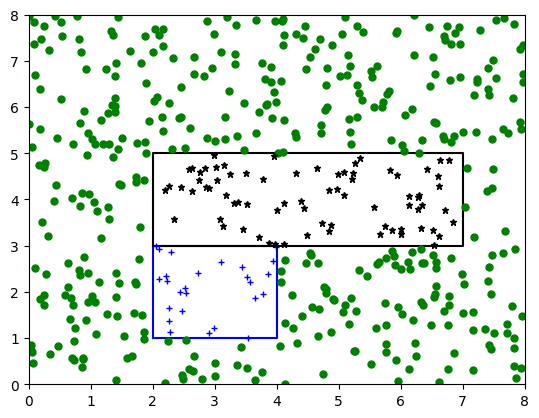

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(578)
# Coordinates of the rectangles
xa, xb, ya, yb = 2, 4, 1, 3
xa2, xb2, ya2, yb2 = 2, 7, 3, 5

# Draw rectangles
plt.plot([xa, xb, xb, xa, xa], [ya, ya, yb, yb, ya], '-b')
plt.plot([xa2, xb2, xb2, xa2, xa2], [ya2, ya2, yb2, yb2, ya2], '-k')

# Generate positive and negative examples
N = 500  # Number of data points
ds = np.zeros((N, 2))
ls = np.zeros(N)

for i in range(N):
    x = np.random.rand() * 8
    y = np.random.rand() * 8
    ds[i, 0] = x
    ds[i, 1] = y
    
    # +ve if falls in the rectangle, -ve otherwise
    if xa < x < xb and ya < y < yb:
        ls[i] = 1
        plt.plot(x, y, 'b+', markersize=5)
    elif xa2 < x < xb2 and ya2 < y < yb2:
        ls[i] = 2
        plt.plot(x, y, 'k*', markersize=5)
    else:
        ls[i] = 0
        plt.plot(x, y, 'go', markersize=5)

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

# Undergraduate assignment (90pts or 30pts per problem)
1. From the generated data, train a parametric classifier assuming multivariate Gaussian distribution. Here you'll need to select the appropriate complexity of the model as discussed in Sections 5.5. and 5.6 of the book. I highly advise thinking on your own: in the past wrong ideas propagated through the class resulting in almost everyone getting a lower grade. 
2. Discuss how the number of data points in the dataset impacts parametric classifier's accuracy.  
3. Visualize  results obtained by the classifier on an independent test set drawn from the same classes C1 and C2 and discuss possible reasons for results being different (or not different).

Hints:  
1. Use SCIPY functions multivariate_normal (found in scipy.stats). These will save a lot coding. 
2. Write two functions of your own: gtrain and grec. Function classpdf=gtrain(x) may take data for a given class (x) and return parameters of the multivariate normal distribution (classpdf). Function clabels=grec(classpdf1, classpdf2, x) may take pdfs for two classes (classpdf1 and classpdf2), perform classification of data matrix (x) and return a vector of labels (clabels). 
3. For part 3 of the assignment, vary the number points (for example, from 50 to 1000). Train the model on one dataset and validate on another. Plot the graph of how the classification error (y axis) changes with the growing number of data points (x axis). Provide conclusions. 


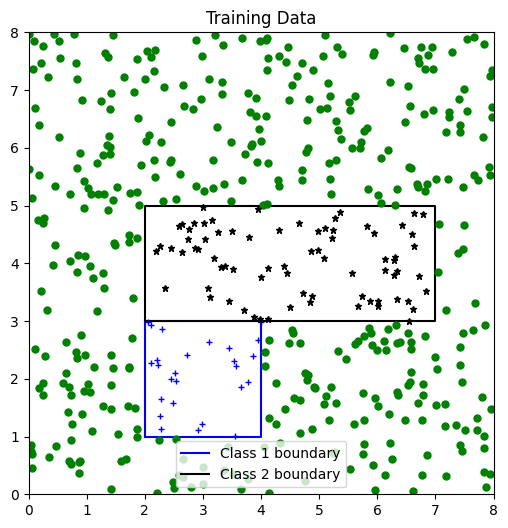

Test classification error: 0.094


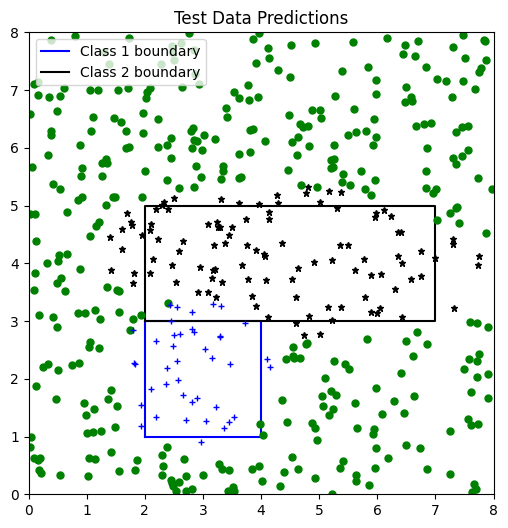

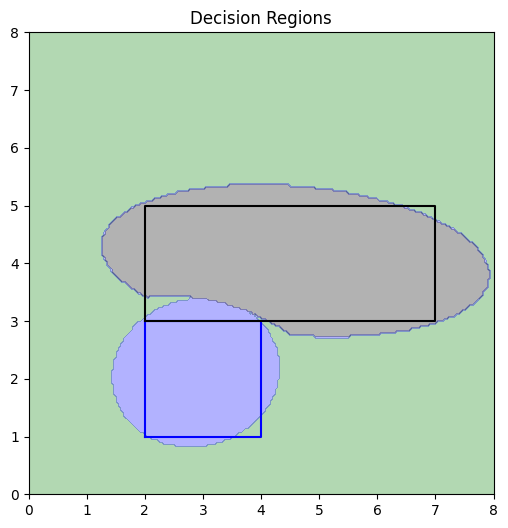

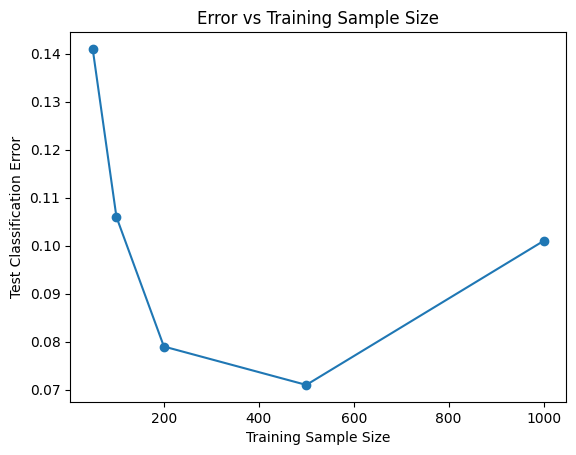

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def generate_data(N):
    """
    Generates N points uniformly in [0,8]x[0,8].
    Points falling inside the first rectangle are labeled 1,
    those inside the second rectangle are labeled 2,
    and all other points are labeled 0.
    """
    
    ds = np.zeros((N, 2))
    ls = np.zeros(N)
    for i in range(N):
        x = np.random.rand() * 8
        y = np.random.rand() * 8
        ds[i] = [x, y]
        if xa < x < xb and ya < y < yb:
            ls[i] = 1
        elif xa2 < x < xb2 and ya2 < y < yb2:
            ls[i] = 2
        else:
            ls[i] = 0
    return ds, ls

def gtrain(x):
    """
    Given an array x of points from one class,
    returns a dictionary with:
      'mean': estimated mean vector,
      'cov': estimated covariance matrix,
      'threshold': a rejection threshold computed as the 
                   minimum training probability density.
                   
    """
    mu = np.mean(x, axis=0)
    cov = np.cov(x, rowvar=False)
    pdf_values = multivariate_normal.pdf(x, mean=mu, cov=cov)
    threshold = np.min(pdf_values)
    return {'mean': mu, 'cov': cov, 'threshold': threshold}

def grec(classpdf1, classpdf2, x):
    """
    Given two dictionaries for classes 1 and 2 and a set of data points x,
    computes the class-conditional densities and assigns labels.
    If the maximum density for a point is below the threshold the point is labeled as 0.
    
    """
    p1 = multivariate_normal.pdf(x, mean=classpdf1['mean'], cov=classpdf1['cov'])
    p2 = multivariate_normal.pdf(x, mean=classpdf2['mean'], cov=classpdf2['cov'])
    # Assign based on which density is higher
    pred = np.where(p1 > p2, 1, 2)
    
    # Implement rejection mechanic
    pred[(pred == 1) & (p1 < classpdf1['threshold'])] = 0
    pred[(pred == 2) & (p2 < classpdf2['threshold'])] = 0
    return pred


train_data, train_labels = ds, ls

plt.figure(figsize=(6,6))
# Boundary plot
plt.plot([xa, xb, xb, xa, xa], [ya, ya, yb, yb, ya], '-b', label='Class 1 boundary')
plt.plot([xa2, xb2, xb2, xa2, xa2], [ya2, ya2, yb2, yb2, ya2], '-k', label='Class 2 boundary')
# Plot points with label.
for point, label in zip(train_data, train_labels):
    if label == 1:
        plt.plot(point[0], point[1], 'b+', markersize=5)
    elif label == 2:
        plt.plot(point[0], point[1], 'k*', markersize=5)
    else:
        plt.plot(point[0], point[1], 'go', markersize=5)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.title("Training Data")
plt.legend()
plt.show()

# Train the classifer with the given class 1 and class 2 data
train_data_class1 = train_data[train_labels == 1]
train_data_class2 = train_data[train_labels == 2]
pdf1 = gtrain(train_data_class1)
pdf2 = gtrain(train_data_class2)

# Generate new test set
N_test = 500
test_data, test_labels = generate_data(N_test)

# Classify the new test set
pred_labels = grec(pdf1, pdf2, test_data)

# Compute classification error
error = np.mean(pred_labels != test_labels)
print("Test classification error:", error)

# 4. Plot test data with predicted labels and actual boundary shown
plt.figure(figsize=(6,6))
plt.plot([xa, xb, xb, xa, xa], [ya, ya, yb, yb, ya], '-b', label='Class 1 boundary')
plt.plot([xa2, xb2, xb2, xa2, xa2], [ya2, ya2, yb2, yb2, ya2], '-k', label='Class 2 boundary')
for point, true_label, pred_label in zip(test_data, test_labels, pred_labels):
    if pred_label == 1:
        marker = 'b+'
    elif pred_label == 2:
        marker = 'k*'
    else:
        marker = 'go'
    plt.plot(point[0], point[1], marker, markersize=5)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.title("Test Data Predictions")
plt.legend()
plt.show()

# Plot the trained boundary
xx, yy = np.meshgrid(np.linspace(0, 8, 200), np.linspace(0, 8, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_pred = grec(pdf1, pdf2, grid_points)
grid_pred = grid_pred.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, grid_pred, levels=[-0.5, 0.5, 1.5, 2.5], colors=['green','blue','black'], alpha=0.3)
plt.plot([xa, xb, xb, xa, xa], [ya, ya, yb, yb, ya], '-b')
plt.plot([xa2, xb2, xb2, xa2, xa2], [ya2, ya2, yb2, yb2, ya2], '-k')
plt.title("Decision Regions")
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

# 6. Experiment: Impact of training sample size on classification error
sample_sizes = [50, 100, 200, 500, 1000]
errors = []

# Generate a large sample size of data to test classifiers trained on a variety of sample sizes
N_test_fixed = 1000
test_data_fixed, test_labels_fixed = generate_data(N_test_fixed)

for N in sample_sizes:
    # Generate a training set of size N
    data, labels = generate_data(N)
    
    data_c1 = data[labels == 1]
    data_c2 = data[labels == 2]
    
    pdf1_temp = gtrain(data_c1)
    pdf2_temp = gtrain(data_c2)
    pred_temp = grec(pdf1_temp, pdf2_temp, test_data_fixed)
    err_temp = np.mean(pred_temp != test_labels_fixed)
    errors.append(err_temp)

plt.figure()
plt.plot(sample_sizes, errors, marker='o')
plt.xlabel("Training Sample Size")
plt.ylabel("Test Classification Error")
plt.title("Error vs Training Sample Size")
plt.show()